라이브러리

In [19]:
import pandas as pd
from keras.utils import *
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import matplotlib.pyplot as plt

데이터셋 설정

In [20]:
japonica_training = pd.DataFrame()
japonica_validation = pd.DataFrame()
for i in range(5):
    tank = i + 1
    japonica_validation_food_supply_tb = pd.read_csv("dataset/japonica_validation_food_supply_tb.csv")
    japonica_validation_sensor_val_tb = pd.read_csv("dataset/japonica_validation_sensor_val_tb.csv")
    japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['tank_id']==tank]
    japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]
    japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
    japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
    japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    japonica_validation_sensor_val_tb['date'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt']).dt.date
    japonica_validation_food_supply_tb['date'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt']).dt.date
    common_dates = japonica_validation_sensor_val_tb['date'].isin(japonica_validation_food_supply_tb['date'])
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[common_dates]
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.drop('date', axis=1)
    japonica_validation_sensor_val_tb.set_index('mea_dt', inplace=True)
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.resample('30min').mean()
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.reset_index()
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb.dropna()
    validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()
    to_delete = validation_counts[validation_counts != 48].index
    japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
    japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
    japonica_validation_features = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
    japonica_validation_features['mea_dt'] = pd.to_datetime(japonica_validation_features['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
    feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
    japonica_validation_features = japonica_validation_features[feature_origin]
    japonica_validation_features = japonica_validation_features.fillna(0)
    japonica_validation_features.set_index('mea_dt', inplace=True)
    japonica_validation_data = japonica_validation_features.sort_index()
    japonica_validation_data = japonica_validation_data.reset_index()
    japonica_validation_data = japonica_validation_data[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
    japonica_validation = pd.concat([japonica_validation, japonica_validation_data])
    japonica_validation.reset_index(drop=True, inplace=True)


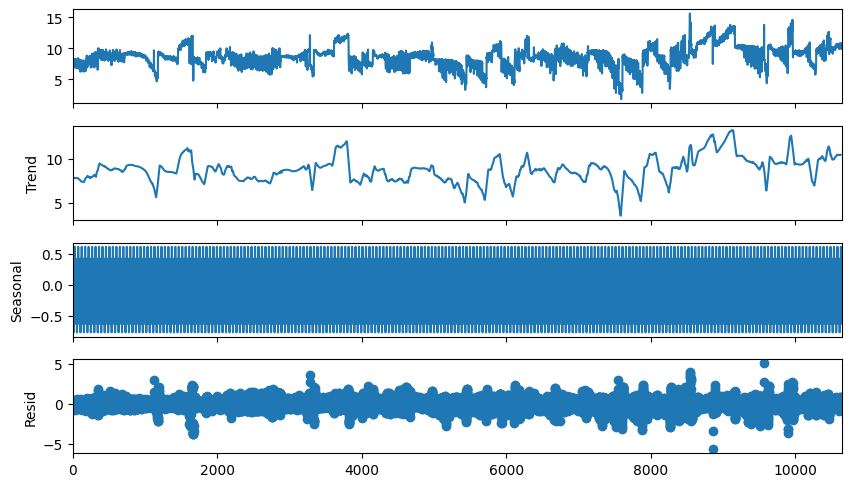

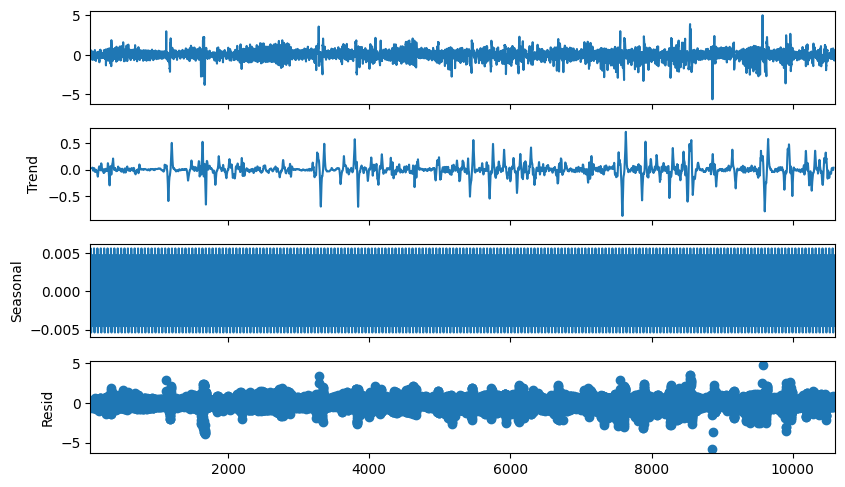

In [21]:
japonica_validation_features_y = japonica_validation[['do_mg']]
dec = seasonal_decompose(japonica_validation_features_y, model='additive', period=48)
fig = dec.plot()
fig.set_size_inches(9, 5)
japonica_validation_features_y_trend = pd.DataFrame(dec.trend)
japonica_validation_features_y_seasonal = pd.DataFrame(dec.seasonal)
japonica_validation_features_y_resid = pd.DataFrame(dec.resid)
japonica_validation_features_3h_do = japonica_validation_features_y.iloc[54:-48]
japonica_validation_features_y_trend_3h = japonica_validation_features_y_trend.iloc[54:-48]
japonica_validation_features_y_seasonal_3h = japonica_validation_features_y_seasonal.iloc[54:-48]
japonica_validation_features_y_resid_3h = japonica_validation_features_y_resid.iloc[54:-48]
japonica_validation_features_y_trend = japonica_validation_features_y_trend.iloc[48:-54]
japonica_validation_features_y_seasonal = japonica_validation_features_y_seasonal.iloc[48:-54]
japonica_validation_features_y_resid = japonica_validation_features_y_resid.iloc[48:-54]
dec = seasonal_decompose(japonica_validation_features_y_resid, model='additive', period=48)
fig = dec.plot()
fig.set_size_inches(9, 5)
japonica_validation_features_y_resid_trend = pd.DataFrame(dec.trend)
japonica_validation_features_y_resid_seasonal = pd.DataFrame(dec.seasonal)
japonica_validation_features_y_resid_resid = pd.DataFrame(dec.resid)
japonica_validation_features_3h_do = japonica_validation_features_3h_do.iloc[48:-48]
japonica_validation_features_y_trend_3h = japonica_validation_features_y_trend.iloc[48:-48]
japonica_validation_features_y_seasonal_3h = japonica_validation_features_y_seasonal.iloc[48:-48]
japonica_validation_features_y_resid_3h = japonica_validation_features_y_resid.iloc[48:-48]
japonica_validation_features_y_resid_trend_3h = japonica_validation_features_y_resid_trend.iloc[48:-48]
japonica_validation_features_y_resid_seasonal_3h = japonica_validation_features_y_resid_seasonal.iloc[48:-48]
japonica_validation_features_y_resid_resid_3h = japonica_validation_features_y_resid_resid.iloc[48:-48]
japonica_validation_features_y_trend = japonica_validation_features_y_trend.iloc[48:-48]
japonica_validation_features_y_seasonal = japonica_validation_features_y_seasonal.iloc[48:-48]
japonica_validation_features_y_resid = japonica_validation_features_y_resid.iloc[48:-48]
japonica_validation_features_y_resid_trend = japonica_validation_features_y_resid_trend.iloc[48:-48]
japonica_validation_features_y_resid_seasonal = japonica_validation_features_y_resid_seasonal.iloc[48:-48]
japonica_validation_features_y_resid_resid = japonica_validation_features_y_resid_resid.iloc[48:-48]
name_mapping = {'trend': 'resid_trend',
                'seasonal': 'resid_seasonal',
                'resid': 'resid_resid'}
japonica_validation_features_y_resid_trend.rename(columns=name_mapping, inplace=True)
japonica_validation_features_y_resid_seasonal.rename(columns=name_mapping, inplace=True)
japonica_validation_features_y_resid_resid.rename(columns=name_mapping, inplace=True)
japonica_validation_features_y_resid_trend_3h.rename(columns=name_mapping, inplace=True)
japonica_validation_features_y_resid_seasonal_3h.rename(columns=name_mapping, inplace=True)
japonica_validation_features_y_resid_resid_3h.rename(columns=name_mapping, inplace=True)
japonica_validation = japonica_validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']]
japonica_validation = japonica_validation.iloc[96:-102]
japonica_validation.reset_index(drop=True, inplace=True)
japonica_validation_features_3h_do.reset_index(drop=True, inplace=True)
japonica_validation_features_y_trend_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_seasonal_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_trend_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_seasonal_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_resid_3h.reset_index(drop=True, inplace=True)
japonica_validation_features_y_trend.reset_index(drop=True, inplace=True)
japonica_validation_features_y_seasonal.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_trend.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_seasonal.reset_index(drop=True, inplace=True)
japonica_validation_features_y_resid_resid.reset_index(drop=True, inplace=True)

In [22]:
japonica_decompose = pd.concat([japonica_validation, japonica_validation_features_y_trend, japonica_validation_features_y_seasonal, japonica_validation_features_y_resid, japonica_validation_features_y_resid_trend, japonica_validation_features_y_resid_seasonal, japonica_validation_features_y_resid_resid], axis=1)
japonica_decompose_3h = pd.concat([japonica_validation_features_3h_do, japonica_validation_features_y_trend_3h, japonica_validation_features_y_seasonal_3h, japonica_validation_features_y_resid_3h, japonica_validation_features_y_resid_trend_3h, japonica_validation_features_y_resid_seasonal_3h, japonica_validation_features_y_resid_resid_3h], axis=1)
name_mapping = {'do_mg': 'do_mg_3h',
                'trend': 'trend_3h',
                'seasonal': 'seasonal_3h',
                'resid': 'resid_3h',
                'do_mg': 'do_mg_3h',
                'resid_trend': 'resid_trend_3h',
                'resid_seasonal': 'resid_seasonal_3h',
                'resid_resid': 'resid_resid_3h'}
japonica_decompose_3h.rename(columns=name_mapping, inplace=True)
japonica_validation = pd.concat([japonica_decompose, japonica_decompose_3h], axis=1)
japonica_validation = japonica_validation[['do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'feed_quantity', 'water_quantity', 'do_mg_3h', 'trend_3h', 'seasonal', 'resid_3h']]
japonica_validation['trend_3h+resid_3h'] = japonica_validation['trend_3h'] + japonica_validation['resid_3h']
japonica_validation['seasonal+resid_3h'] = japonica_validation['seasonal'] + japonica_validation['resid_3h']

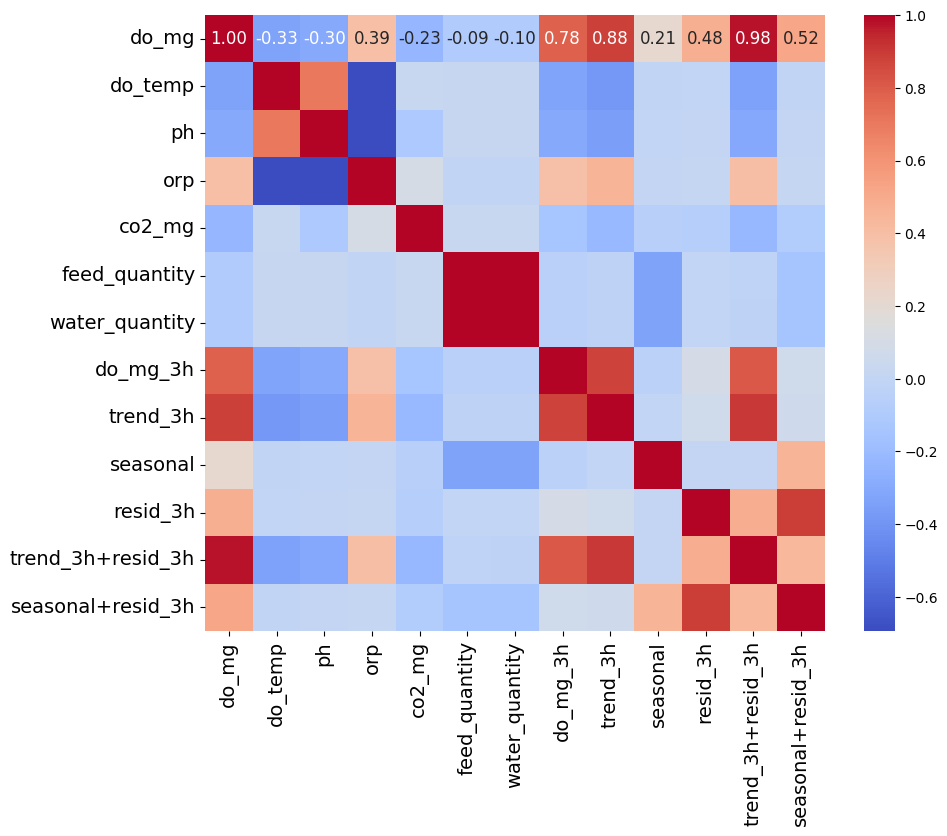

In [23]:
correlation_matrix = japonica_validation.corr()
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
plt.show()